In [6]:
import torch
torch.cuda.empty_cache()

In [1]:
from torchvision.datasets import MNIST

download_root = './MNIST_DATASET'
train_dataset = MNIST(download_root, train=True, download=True)


In [2]:
import torch
import numpy as np
import cv2
import wandb
import time
# import os

from denoising_diffusion_pytorch import Unet, GaussianDiffusion

# os.environ['WANDB_NOTEBOOK_NAME'] = "KJM"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8)
).to(device)
model.train()

diffusion = GaussianDiffusion(
    model,
    image_size = 128,
    timesteps = 1000,   # number of steps
    loss_type = 'l1'    # L1 or L2
).to(device)


# training_images = torch.rand(8, 3, 128, 128) # images are normalized from 0 to 1
MNIST_images = train_dataset.data.unsqueeze(1).repeat(1,3,1,1).numpy()
training_images = torch.zeros(60000,3,128,128)
# print(MNIST_images.shape)
for i in range(60000):
    newsize = (128,128)
    img = cv2.resize(MNIST_images[i].transpose(1,2,0),newsize)
    training_images[i] = torch.Tensor(img.transpose(2,0,1))/255.0
# print(training_images.shape)
# training_images = training_images.to(device)
# loss = diffusion(training_images)
# loss.backward()
# after a lot of training

# sampled_images = diffusion.sample(batch_size = 8)
# sampled_images.shape # (4, 3, 128, 128)

In [3]:
wandb.init(project='DiffusionMNIST_test1',entity='jongminkim')
wandb.run.name = time.strftime('%Y%m%d_%H%M%S',time.localtime(time.time()))
wandb.watch(model)

starttime = time.time()
BATCH=32
optim = torch.optim.Adam(diffusion.parameters(), lr=3e-4)
print("start training")
for i in range(50000):
    i += 1
    idx = torch.randint(0,60000,(BATCH,), device='cpu')
    trnimg = training_images[idx].to(device)
    loss = diffusion(trnimg)
    # loss = diffusion(training_images)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if i % 100 == 0:
        wandb.log({"loss": loss})
    if i % 500 == 0:
        print(str(i)+"th step : "+str(loss.item())+", time : "+str(time.time()-starttime))
    if i % 10000 == 0:
        torch.save(model.state_dict(), "weights/weights_MNIST_"+str(i//1000)+"k_"+time.strftime('%m%d',time.localtime(time.time()))+".pt")
print("Total Elapsed Time : "+str(time.time()-starttime))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jongminkim. Use `wandb login --relogin` to force relogin


start training
500th step : 0.05945609137415886, time : 217.2652862071991
1000th step : 0.03762514144182205, time : 434.9984393119812
1500th step : 0.024510866031050682, time : 652.9966106414795
2000th step : 0.030901562422513962, time : 871.251217842102
2500th step : 0.03174714744091034, time : 1089.3278710842133
3000th step : 0.02497163973748684, time : 1307.5381984710693
3500th step : 0.02760889194905758, time : 1525.6197905540466
4000th step : 0.02360491082072258, time : 1743.7930798530579
4500th step : 0.02129640243947506, time : 1961.8688068389893
5000th step : 0.020300166681408882, time : 2180.0217616558075
5500th step : 0.020807316526770592, time : 2398.0464844703674
6000th step : 0.022489752620458603, time : 2616.1737213134766
6500th step : 0.0197000689804554, time : 2834.196793794632
7000th step : 0.0220008697360754, time : 3052.331531524658
7500th step : 0.023329881951212883, time : 3270.31795501709
8000th step : 0.019903071224689484, time : 3488.4332234859467
8500th step : 

In [25]:
starttime = time.time()
BATCH=32
optim = torch.optim.Adam(diffusion.parameters(), lr=3e-4)
model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8)
).to(device)
model.train()
model.load_state_dict(torch.load("weights/weights_MNIST_200k_0423.pt",map_location=device))
diffusion = GaussianDiffusion(
    model,
    image_size = 128,
    timesteps = 1000,   # number of steps
    loss_type = 'l1'    # L1 or L2
).to(device)
print("start training")
for i in range(300000,400000):
    i += 1
    idx = torch.randint(0,60000,(BATCH,), device='cpu')
    trnimg = training_images[idx].to(device)
    loss = diffusion(trnimg)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if i % 1000 == 0:
        print(str(i)+"th step : "+str(loss.item())+", time : "+str(time.time()-starttime))
    if i % 10000 == 0:
        torch.save(model.state_dict(), "weights/weights_MNIST_"+str(i//1000)+"k_"+time.strftime('%m%d',time.localtime(time.time()))+".pt")
print("Total Elapsed Time : "+str(time.time()-starttime))

start training
201000th step : 0.014863542281091213, time : 428.95938324928284
202000th step : 0.014831606298685074, time : 858.4252099990845
203000th step : 0.015480142086744308, time : 1288.139243364334
204000th step : 0.01563074439764023, time : 1717.6500787734985
205000th step : 0.014019961468875408, time : 2147.308490037918
206000th step : 0.014856058172881603, time : 2578.666890144348
207000th step : 0.014459426514804363, time : 3009.130256652832
208000th step : 0.01495362352579832, time : 3439.6713573932648
209000th step : 0.01522151194512844, time : 3870.161752462387
210000th step : 0.016053881496191025, time : 4300.756332397461
211000th step : 0.014756637625396252, time : 4731.284953117371
212000th step : 0.01504208892583847, time : 5161.745586872101
213000th step : 0.017200689762830734, time : 5593.7174949646
214000th step : 0.016509398818016052, time : 6024.349285840988
215000th step : 0.01708851382136345, time : 6454.775699853897
216000th step : 0.015648040920495987, time :

In [32]:
model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8)
).to(device)
model.train()
model.load_state_dict(torch.load("weights/weights_MNIST_50k.pt",map_location=device))
diffusion = GaussianDiffusion(
    model,
    image_size = 128,
    timesteps = 1000,   # number of steps
    loss_type = 'l1'    # L1 or L2
).to(device)

BSIZE = 32
sampled_images = diffusion.sample(batch_size = BSIZE)
print(sampled_images.shape)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([32, 3, 128, 128])


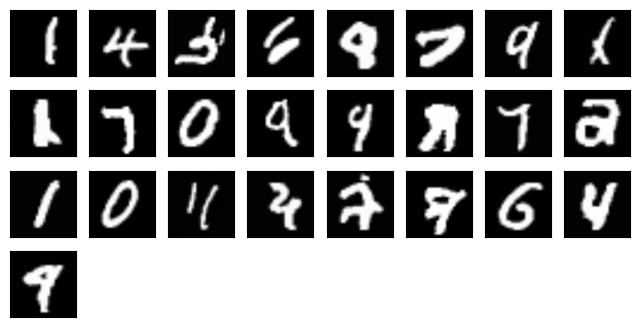

In [31]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

BB = (BSIZE+7)//8
fig = plt.figure(figsize = (8,BB))

for i in range(BSIZE):
    ax = fig.add_subplot(BB,8,i+1)
    img = (sampled_images[i,:].to('cpu').squeeze(0).permute(1,2,0)).numpy()
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_xticks([]), ax.set_yticks([])

In [21]:
diffusion.objective

'pred_noise'

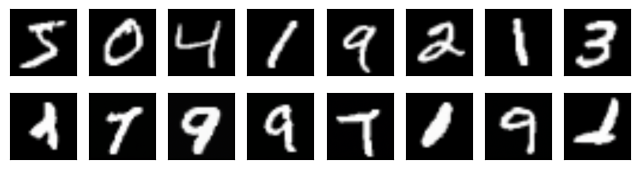

In [27]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

fig = plt.figure(figsize = (8,2))
for i in range(8):
    ax = fig.add_subplot(2,8,i+1)
    img = (training_images[i,:].to('cpu').squeeze(0).permute(1,2,0)).numpy()
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_xticks([]), ax.set_yticks([])

for i in range(8):
    ax = fig.add_subplot(2,8,i+9)
    img = (sampled_images[i,:].to('cpu').squeeze(0).permute(1,2,0)).numpy()
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_xticks([]), ax.set_yticks([])

#plt.show()

In [1]:
import numpy as np